In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [8]:
df = pd.read_csv('Input/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [9]:
#Now we will separate the data and labels so that it will be easy for us
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

**Lets normalize the data to the range [0-1]**

In [11]:
#Now lets Normalize the data
#First we will calculate the maximum and minimum value from the training set 
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

#Now we will use the formula (data - min)/(max - min)
train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

#I have converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [12]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false) 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Now let's separate the data for normal ECG from that of abnormal ones
#Normal ECG data
n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

#Abnormal ECG data
an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

tf.Tensor(
[[0.57030463 0.46561658 0.29058117 ... 0.48504233 0.4233502  0.47598344]
 [0.48320588 0.28246963 0.16471253 ... 0.567567   0.4677294  0.2692329 ]
 [0.48144642 0.35151404 0.25972766 ... 0.5479421  0.5077544  0.54298663]
 ...
 [0.41039047 0.24164985 0.13120876 ... 0.5277313  0.5654091  0.5023885 ]
 [0.5397748  0.4140786  0.28101394 ... 0.51266515 0.43706053 0.4426865 ]
 [0.29639772 0.15988176 0.18883787 ... 0.53766966 0.545786   0.40826708]], shape=(2359, 140), dtype=float32)


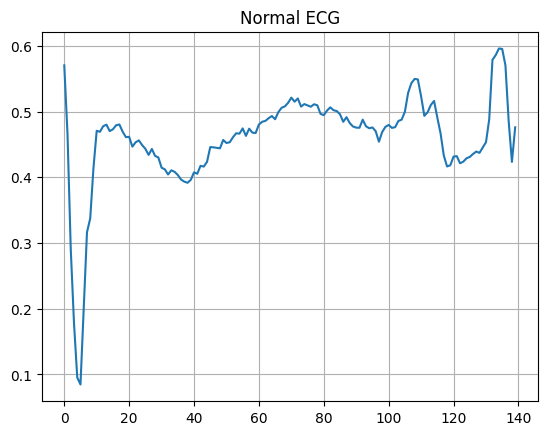

In [13]:
#Lets plot a normal ECG
plt.plot(np.arange(140), n_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

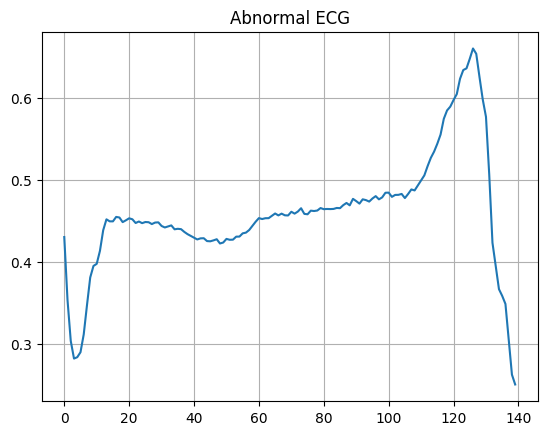

In [14]:
#Lets plot one from abnormal ECG
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

In [15]:
#Now let's define the model!
#Here I have used the Model Subclassing API (but we can also use the Sequential API)
#The model has 2 parts : 1. Encoder and 2. Decoder
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [16]:
#Let's compile and train the model!!
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data))

Epoch 1/20
5/5 [==============================] - 1s 26ms/step - loss: 0.0585 - val_loss: 0.0564
Epoch 2/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0556 - val_loss: 0.0537
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0526 - val_loss: 0.0507
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0495 - val_loss: 0.0472
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.0439
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0405
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0393 - val_loss: 0.0371
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0360 - val_loss: 0.0339
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0331 - val_loss: 0.0313
Epoch 10/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0293
Epoch 11/20
5/5 [=====================

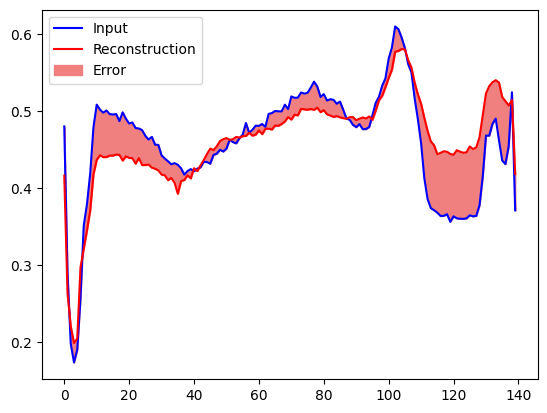

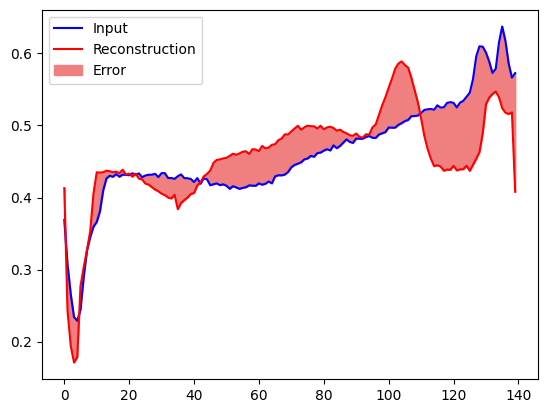

In [17]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

In [18]:
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
t = np.mean(train_loss) + np.std(train_loss)

def prediction(model, data, threshold):
  rec = model(data)
  loss = losses.mae(rec, data)
  return tf.math.less(loss, threshold)
print(t)

0.03270244


In [19]:
pred = prediction(autoencoder, n_test_data, t)
print(pred)

tf.Tensor(
[False  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

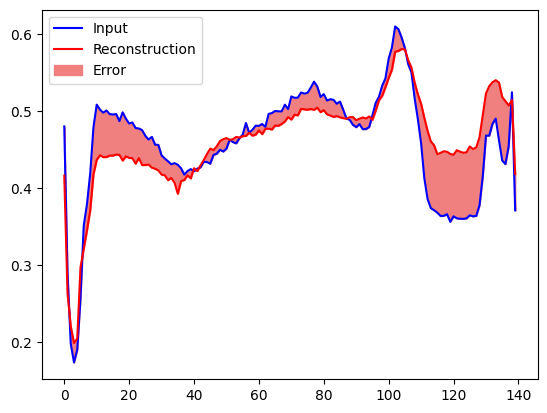

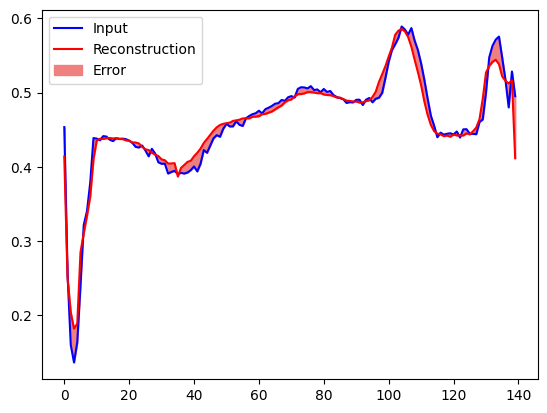

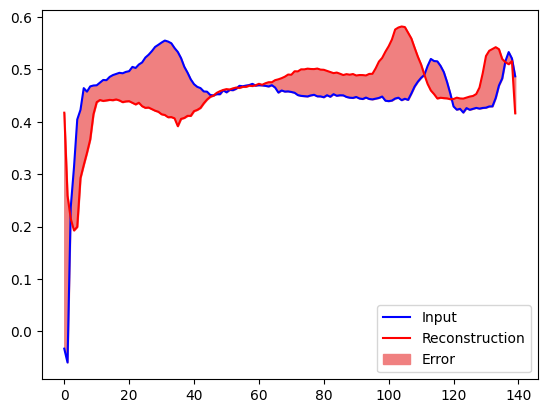

In [20]:
#Lets see some more result visually !!
plot(n_test_data, 0)
plot(n_test_data, 1)
plot(n_test_data, 3)